Machine Learning Assignment:(EMNIST Dataset)
-----------------------------------------------------------------
Tools: Python(Anaconda), scikit-learn, opencv, scikit-image, numpy, pandas, matplotlib, tensorflow with keras, jupyter notebook etc

Task 1:
- Use https://www.nist.gov/node/1298471/emnist-dataset EMNIST ByClass datasets from scikit-learn
- Use matlab file version
- Use pandas to store and view data and perform descriptive statistics
- Use pandas groupby to view data by classes, digits, letters
- Display images of digits
- Use image augmentation to generate larger training dataset (flip, rotate, translate, noise)
- Spliting of train/test datasets
- Logistic Regression modelling using scikit-learn
- Model performance results - precision, recall, F1 Score, ROC Curve
- Print and display confusion matrix
- Write report to explain process and results

Task 2:
- Repeat Task 1 with emnist dataset using tensorflow/keras.

## Setup environment
```
conda create --name emnist_py3 python=3.6
conda install numpy keras tensorflow-gpu==1.6 matplotlib pandas scikit-learn
pip install imgaug opencv-python==3.3.0.9
source activate emnist_py3
```

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [3]:
%matplotlib inline

import keras.backend as K
K.set_image_data_format("channels_first")

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam as Adam
from keras.layers.advanced_activations import LeakyReLU

## Load data
- Use https://www.nist.gov/node/1298471/emnist-dataset EMNIST ByClass datasets from scikit-learn
- Use matlab file version

In [4]:
import scipy.io as spio
emnist = spio.loadmat("datasets/matlab/emnist-byclass.mat")

In [5]:
# explore contents 
for key, value in emnist.items():
    print (key)

dataset
__version__
__header__
__globals__


In [6]:
# explore dataset
emnist['dataset'][0]

array([(array([[(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[35],
       [36],
       [ 6],
       ...,
       [ 5],
       [11],
       [22]], dtype=uint8), array([[2376],
       [3994],
       [3699],
       ...,
       [  26],
       [ 421],
       [1243]], dtype=uint16))]],
      dtype=[('images', 'O'), ('labels', 'O'), ('writers', 'O')]), array([[(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[18],
       [36],
       [ 0],
       ...,
       [28],
       [ 0],
       [ 5]], dtype=uint8), array([[ 464],
       [  12],
       [ 249],
       ...,
       [ 313],
       [ 512],
       [2497]], dtype=uint16))]],
      dtype=[('im

## Input details
- 28-pixel x 28-pixel image (28x28 = 784)
- 8 bit = $2^8$ = 256 different pixel values

In [7]:
# determine location of data
print(emnist['dataset'][0][0][0][0][0][0].shape, \
    emnist['dataset'][0][0][0][0][0][1].shape)

((697932, 784), (697932, 1))


In [8]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

x_train.shape, y_train.shape

# store labels for visualization
train_labels = y_train
test_labels = y_test

## Use pandas 
- to store and view data and perform descriptive statistics

Most common value and median are 0, meaning half of  pixels are blank space.

In [9]:
x_train_df = pd.DataFrame(x_train)
y_train_df = pd.DataFrame(y_train)

In [12]:
x_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,697932.0,697932.0,697932.0,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,...,697932.000000,697932.000000,697932.000000,697932.000000,697932.000000,697932.0,697932.0,697932.0,697932.0,697932.0
mean,0.0,0.0,0.0,0.000009,0.000878,0.004574,0.007309,0.007537,0.007203,0.005109,...,0.000050,0.000047,0.000047,0.000350,0.000046,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.006104,0.242795,0.789262,1.022129,1.055924,1.053376,0.857763,...,0.041895,0.039501,0.039501,0.292068,0.038304,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,5.000000,107.000000,215.000000,217.000000,247.000000,217.000000,217.000000,...,35.000000,33.000000,33.000000,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


In [13]:
print('The most likely pixel to contain part of the hand-written digit is', x_train_df.describe().loc['mean'].idxmax())

The most likely pixel to contain part of the hand-written digit is 330


In [14]:
y_train_df.describe()

,0
count,697932.000000
mean,19.381620
std,17.849636
min,0.000000
25%,4.000000
50%,10.000000
75%,32.000000
max,61.000000


In [15]:
x_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
y_train_df.head()

,0
0,35
1,36
2,6
3,3
4,22


In [10]:
x_train_values = pd.Series(x_train_df.values.ravel())

print (' min value: {}, \n max value: {}, \n mean pixel value: {}, \n median pixel value: {}, \n most common value: {}'.format( \
                x_train_values.min(), \
                x_train_values.max(), \
                x_train_values.mean(), \
                x_train_values.median(), \
                x_train_values.value_counts().idxmax()))

 min value: 0.0, 
 max value: 255.0, 
 mean pixel value: 44.2660179138, 
 median pixel value: 0.0, 
 most common value: 0.0


In [18]:
# all 256 values have been used
len(np.unique(x_train_df.values))

256

In [11]:
y_train_values = pd.Series(y_train_df.values.ravel())

print (' min value: {}, \n max value: {}, \n mean pixel value: {}, \n median pixel value: {}, \n most common value: {}'.format( \
                y_train_values.min(), \
                y_train_values.max(), \
                y_train_values.mean(), \
                y_train_values.median(), \
                y_train_values.value_counts().idxmax()))

 min value: 0, 
 max value: 61, 
 mean pixel value: 19.3816202725, 
 median pixel value: 10.0, 
 most common value: 1


## Use pandas groupby 
- to view data by classes, digits, letters

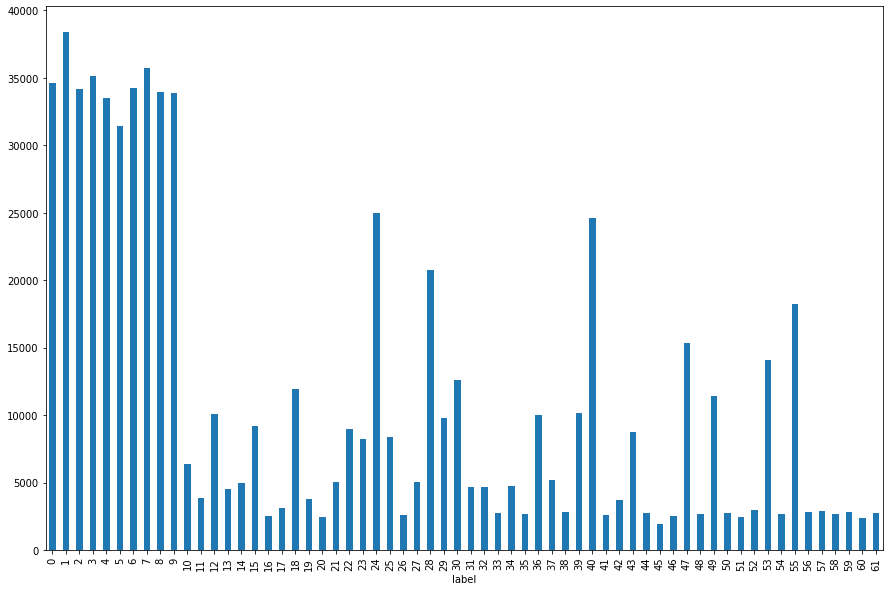

In [25]:
train_df = x_train_df
train_df['label'] = y_train_df
plt.figure(figsize=(15,10))
train_df.groupby('label').label.count().plot.bar()

In [26]:
print('most common class:', y_train_values.value_counts().idxmax())

most common class: 1


In [27]:
# all labels have been used
print (len(np.unique(y_train_df.values)))

62


## Normalise 8-bit values

In [12]:
x_train /= 255
x_test /= 255

# reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28, order="A")
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28, order="A")

x_train.shape, y_train.shape

((697932, 1, 28, 28), (697932, 1))

In [13]:
# onehot encode label
N_LABELS = y_train_values.max() + 1
y_train = keras.utils.to_categorical(y_train, N_LABELS)
y_test = keras.utils.to_categorical(y_test, N_LABELS)

y_train.shape

(697932, 62)

## Reshape test labels
- for confusion matrix

In [14]:
test_labels.shape

(116323, 1)

In [15]:
# test_labels = test_labels.reshape(40000)
test_labels = test_labels.reshape(test_labels.shape[0])

In [16]:
test_labels.shape

(116323,)

## Display images of digits

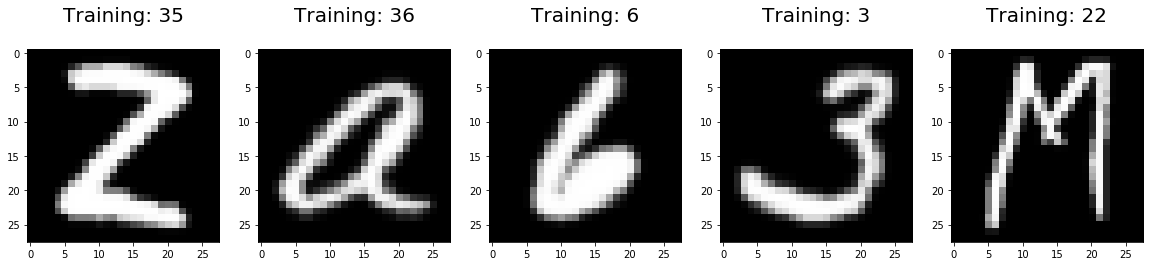

In [33]:
plt.figure(figsize=(20,4))
for index, (image,label) in enumerate(zip(x_train[0:5], train_labels[0:5])):
    plt.subplot(1,5, index + 1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Training: %i\n' % label, fontsize=20)

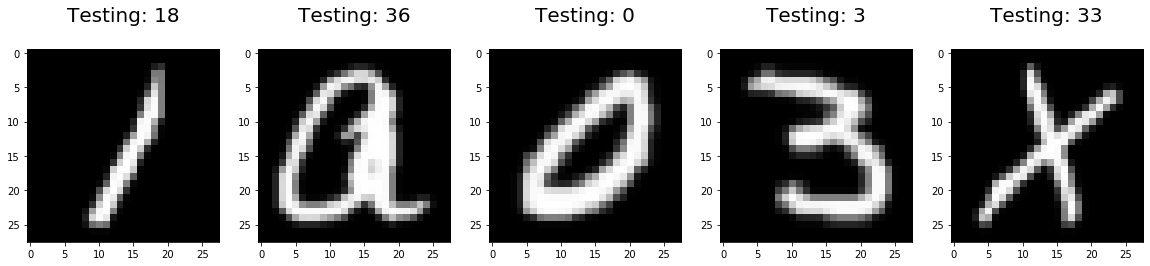

In [34]:
plt.figure(figsize=(20,4))
for index, (image,label) in enumerate(zip(x_test[0:5], test_labels[0:5])):
    plt.subplot(1,5, index + 1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Testing: %i\n' % label, fontsize=20)

## Use image augmentation 
- to generate larger training dataset (flip, rotate, translate, noise)

In [35]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
#     iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.

    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.9, 1.1), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-5, 5),
        shear=(-5, 5)
    )
], random_order=False
) # may not want to apply augmenters in random order for debugging

## Visualise augmentation on few images

In [36]:
x_train_aug10 = seq(images=x_train[0:10])

x_train_app10 = np.concatenate((x_train[0:10],x_train_aug10))
x_train_aug10.shape, x_train_app10.shape

((10, 1, 28, 28), (20, 1, 28, 28))

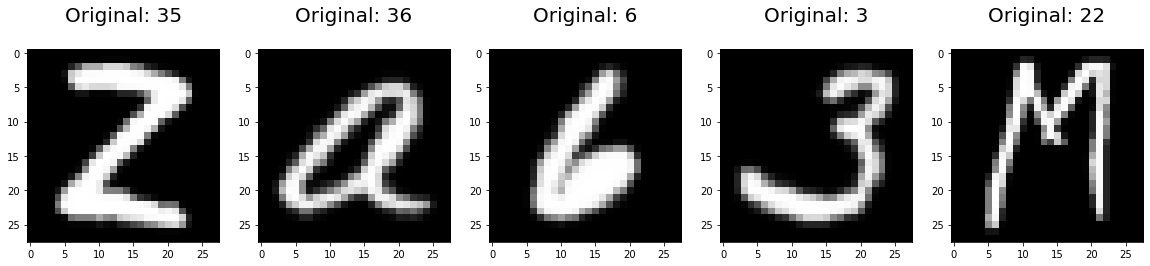

In [37]:
plt.figure(figsize=(20,4))
for index, (image,label) in enumerate(zip(x_train_app10[0:5], train_labels[0:5])):
    plt.subplot(1,5, index + 1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Original: %i\n' % label, fontsize=20)

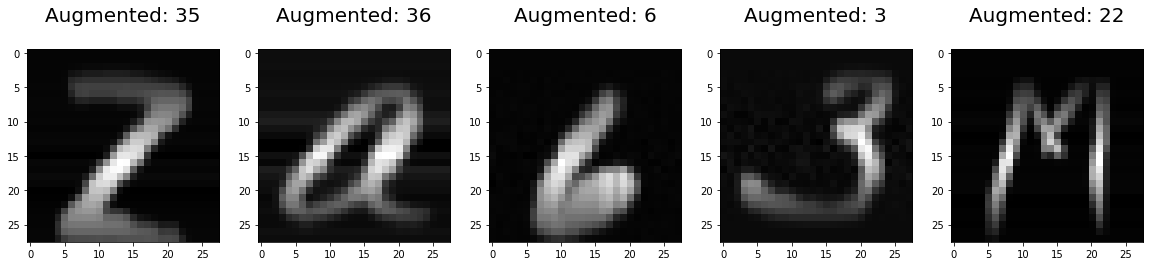

In [38]:
plt.figure(figsize=(20,4))
for index, (image,label) in enumerate(zip(x_train_app10[10:15], train_labels[0:5])):
    plt.subplot(1,5, index + 1)
    plt.imshow(image[0], cmap='gray')
    plt.title('Augmented: %i\n' % label, fontsize=20)

## Add augmented images to training

In [39]:
x_train_aug = seq(images=x_train)

In [40]:
x_train = np.concatenate((x_train,x_train_aug))
y_train = np.concatenate((y_train,y_train))
x_train.shape, y_train.shape

((1395864, 1, 28, 28), (1395864, 62))

In [42]:
# back up training set
np.save('datasets/augmented/byClass_x_train_aug', x_train)
np.save('datasets/augmented/byClass_y_train_aug', y_train)

In [17]:
# load augmented
# x_train = np.load('datasets/augmented/byClass_x_train_aug.npy')
# y_train = np.load('datasets/augmented/byClass_y_train_aug.npy')
# x_train.shape, y_train.shape

((1395864, 1, 28, 28), (1395864, 62))

In [18]:
# due to memory constraint
MAX_RECORDS = 800000
x_train = x_train[0:MAX_RECORDS]
y_train = y_train[0:MAX_RECORDS]

In [19]:
x_train.shape, y_train.shape

((800000, 1, 28, 28), (800000, 62))

## Logistic regression 
- modelling using scikit-learn
- use non CV version to save time

In [51]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(solver='lbfgs',n_jobs=-1)

x_train_lr = x_train.reshape(x_train.shape[0],784)
x_test_lr = x_test.reshape(x_test.shape[0],784)
y_train_lr = np.concatenate((train_labels,train_labels))[0:MAX_RECORDS]

x_train_lr.shape, y_train_lr.shape, x_test_lr.shape

((800000, 784), (800000, 1), (116323, 784))

In [53]:
logReg.fit(x_train_lr, y_train_lr)

/root/anaconda3/envs/emnist_py3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/envs/emnist_py3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
from sklearn.externals import joblib
# Save model
joblib.dump(logReg, 'saved_logreg.pkl') 

/root/anaconda3/envs/emnist_py3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['saved_logreg.pkl']

In [54]:
pred_lr = logReg.predict(x_test_lr)
num_classes = N_LABELS

target_names = ["Class {}".format(i) for i in range(num_classes)]

print(classification_report(test_labels, pred_lr, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.62      0.78      0.69      5778
     Class 1       0.56      0.92      0.70      6330
     Class 2       0.80      0.87      0.83      5869
     Class 3       0.83      0.91      0.87      5969
     Class 4       0.70      0.82      0.75      5619
     Class 5       0.72      0.76      0.74      5190
     Class 6       0.83      0.93      0.88      5705
     Class 7       0.90      0.93      0.92      6139
     Class 8       0.72      0.83      0.77      5633
     Class 9       0.81      0.89      0.85      5686
    Class 10       0.63      0.65      0.64      1062
    Class 11       0.63      0.42      0.50       648
    Class 12       0.63      0.65      0.64      1739
    Class 13       0.72      0.50      0.59       779
    Class 14       0.77      0.51      0.61       851
    Class 15       0.63      0.61      0.62      1440
    Class 16       0.79      0.48      0.60       447
    Class 17       0.70    

/root/anaconda3/envs/emnist_py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4512    5    8 ...    1    0    1]
 [   1 5850    6 ...    1    0    0]
 [  24   19 5122 ...    8    0   33]
 ...
 [   0   11    9 ...  172    7    0]
 [   1   12    0 ...    2   24    1]
 [   0    2  200 ...    3    0   95]]
Normalized confusion matrix
[[7.81e-01 8.65e-04 1.38e-03 ... 1.73e-04 0.00e+00 1.73e-04]
 [1.58e-04 9.24e-01 9.48e-04 ... 1.58e-04 0.00e+00 0.00e+00]
 [4.09e-03 3.24e-03 8.73e-01 ... 1.36e-03 0.00e+00 5.62e-03]
 ...
 [0.00e+00 2.34e-02 1.91e-02 ... 3.66e-01 1.49e-02 0.00e+00]
 [2.62e-03 3.15e-02 0.00e+00 ... 5.25e-03 6.30e-02 2.62e-03]
 [0.00e+00 4.43e-03 4.43e-01 ... 6.65e-03 0.00e+00 2.11e-01]]


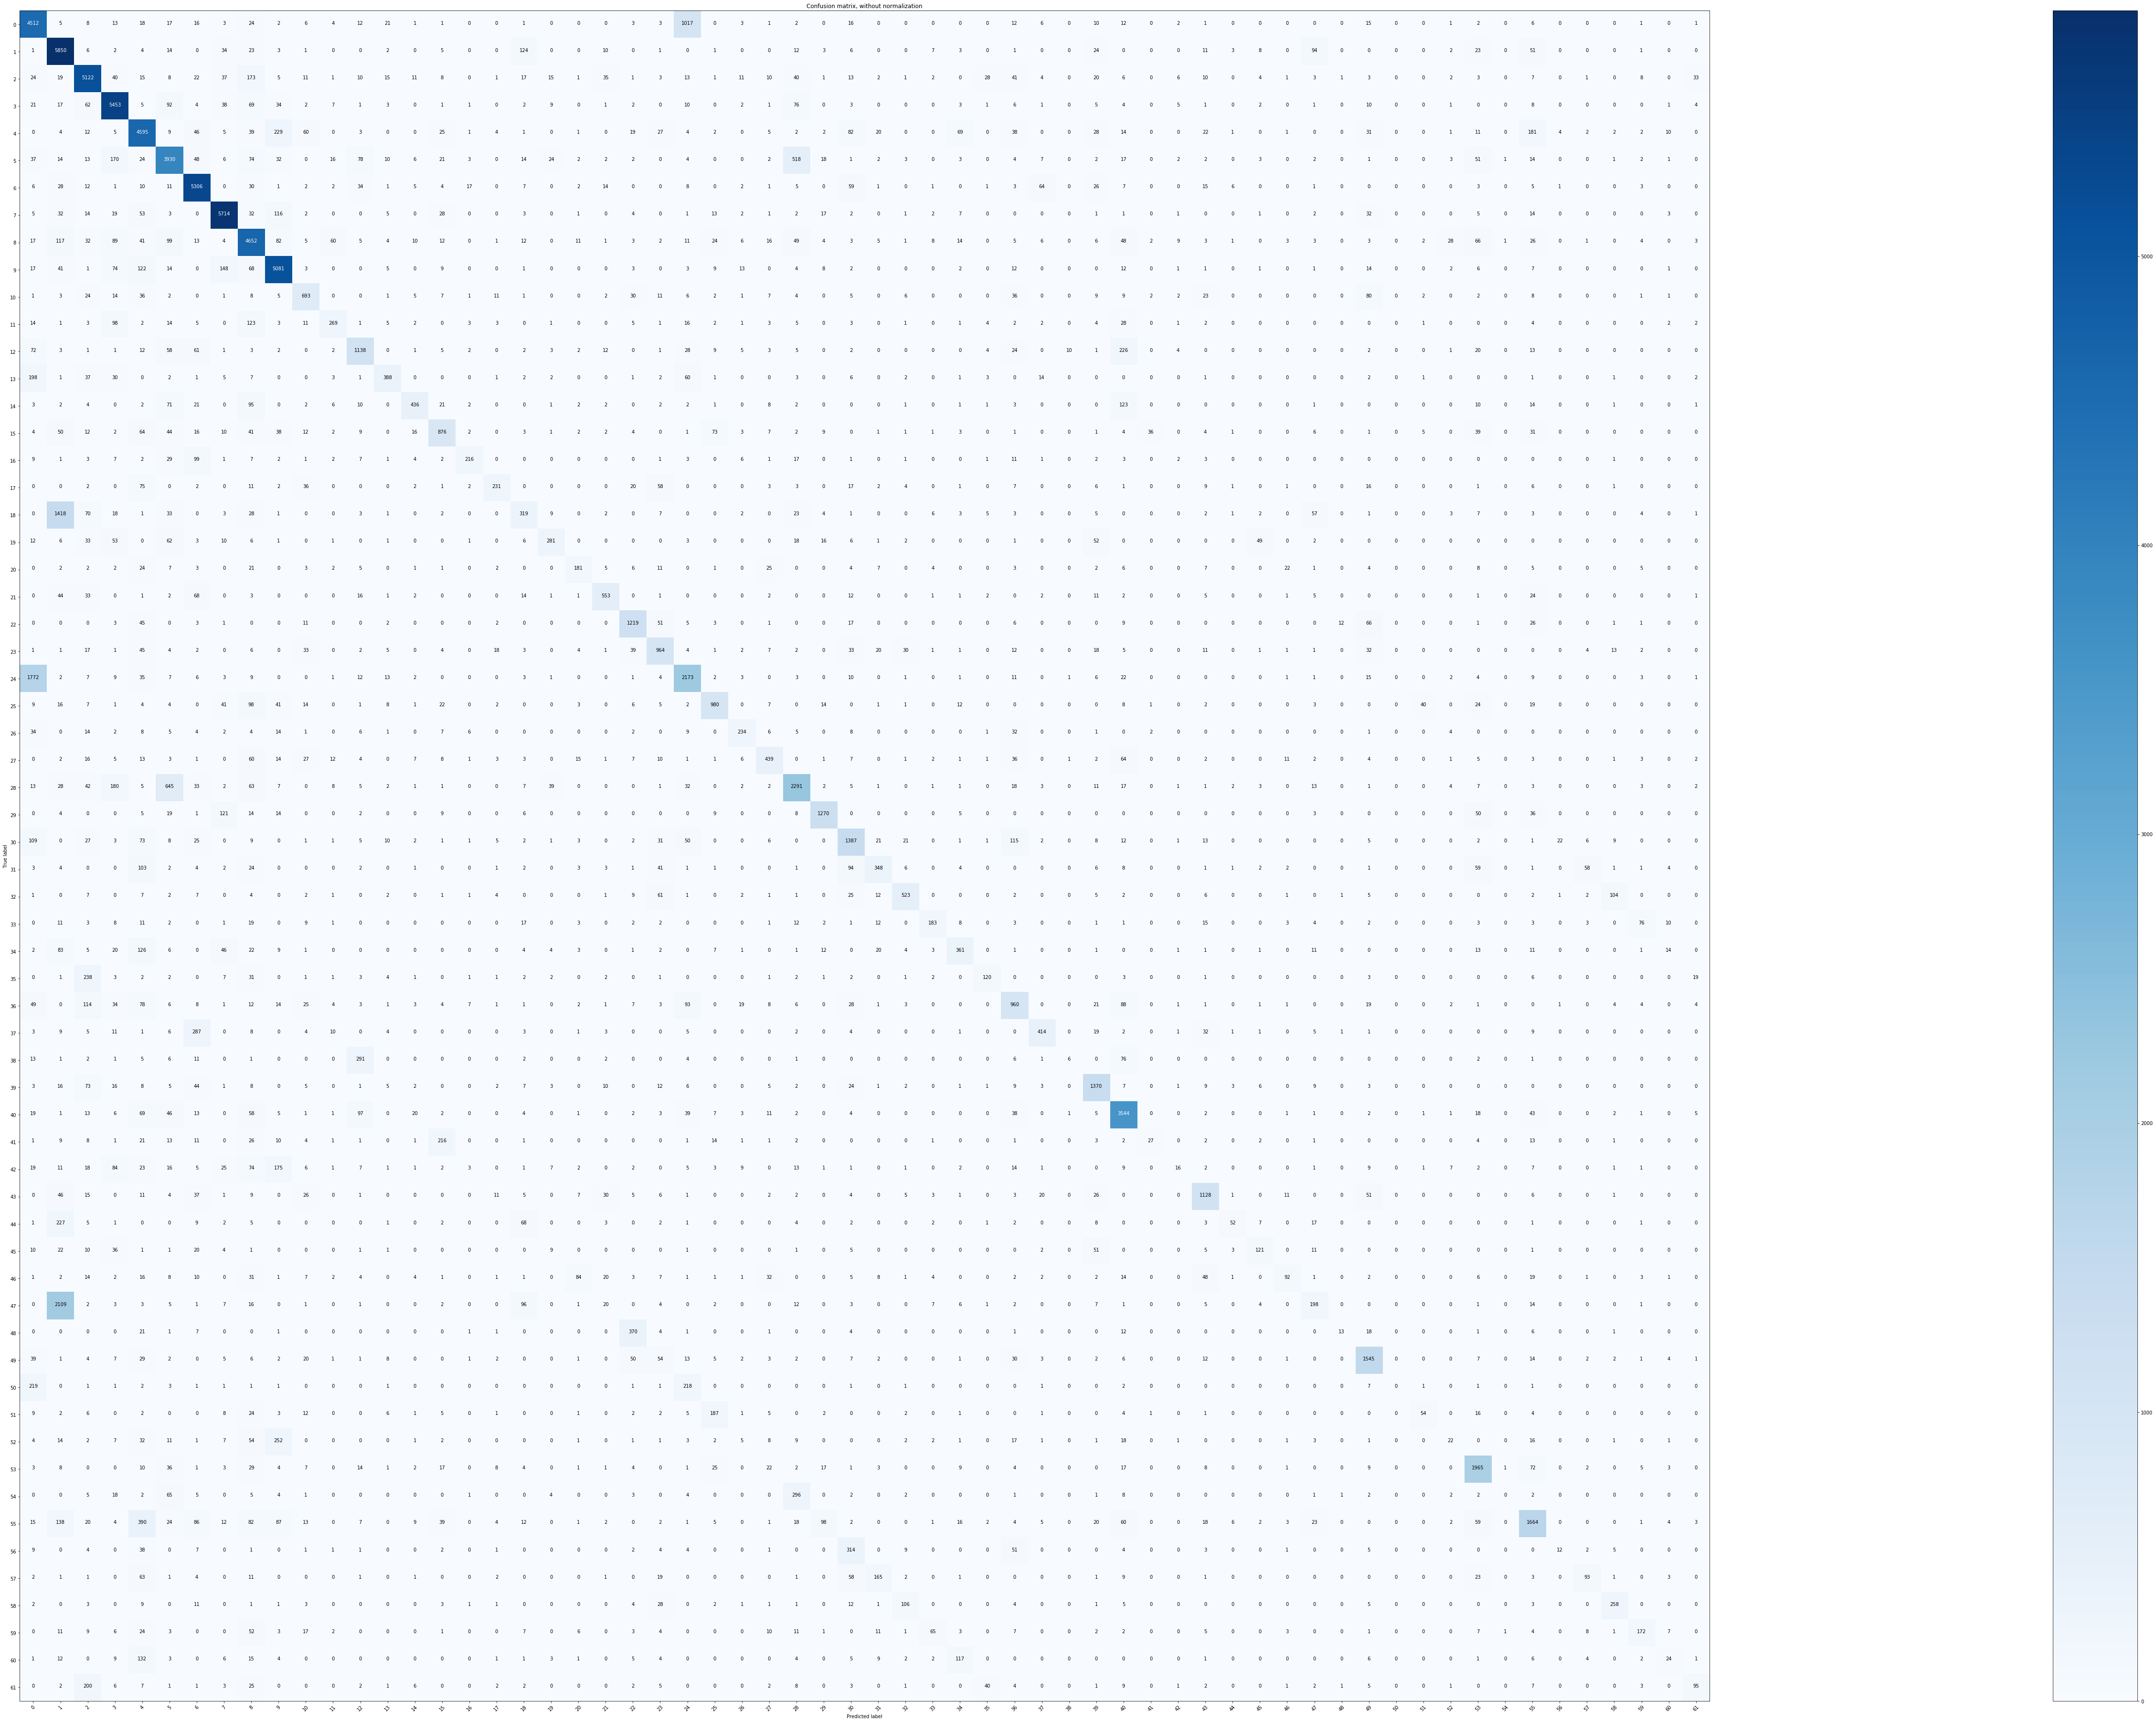

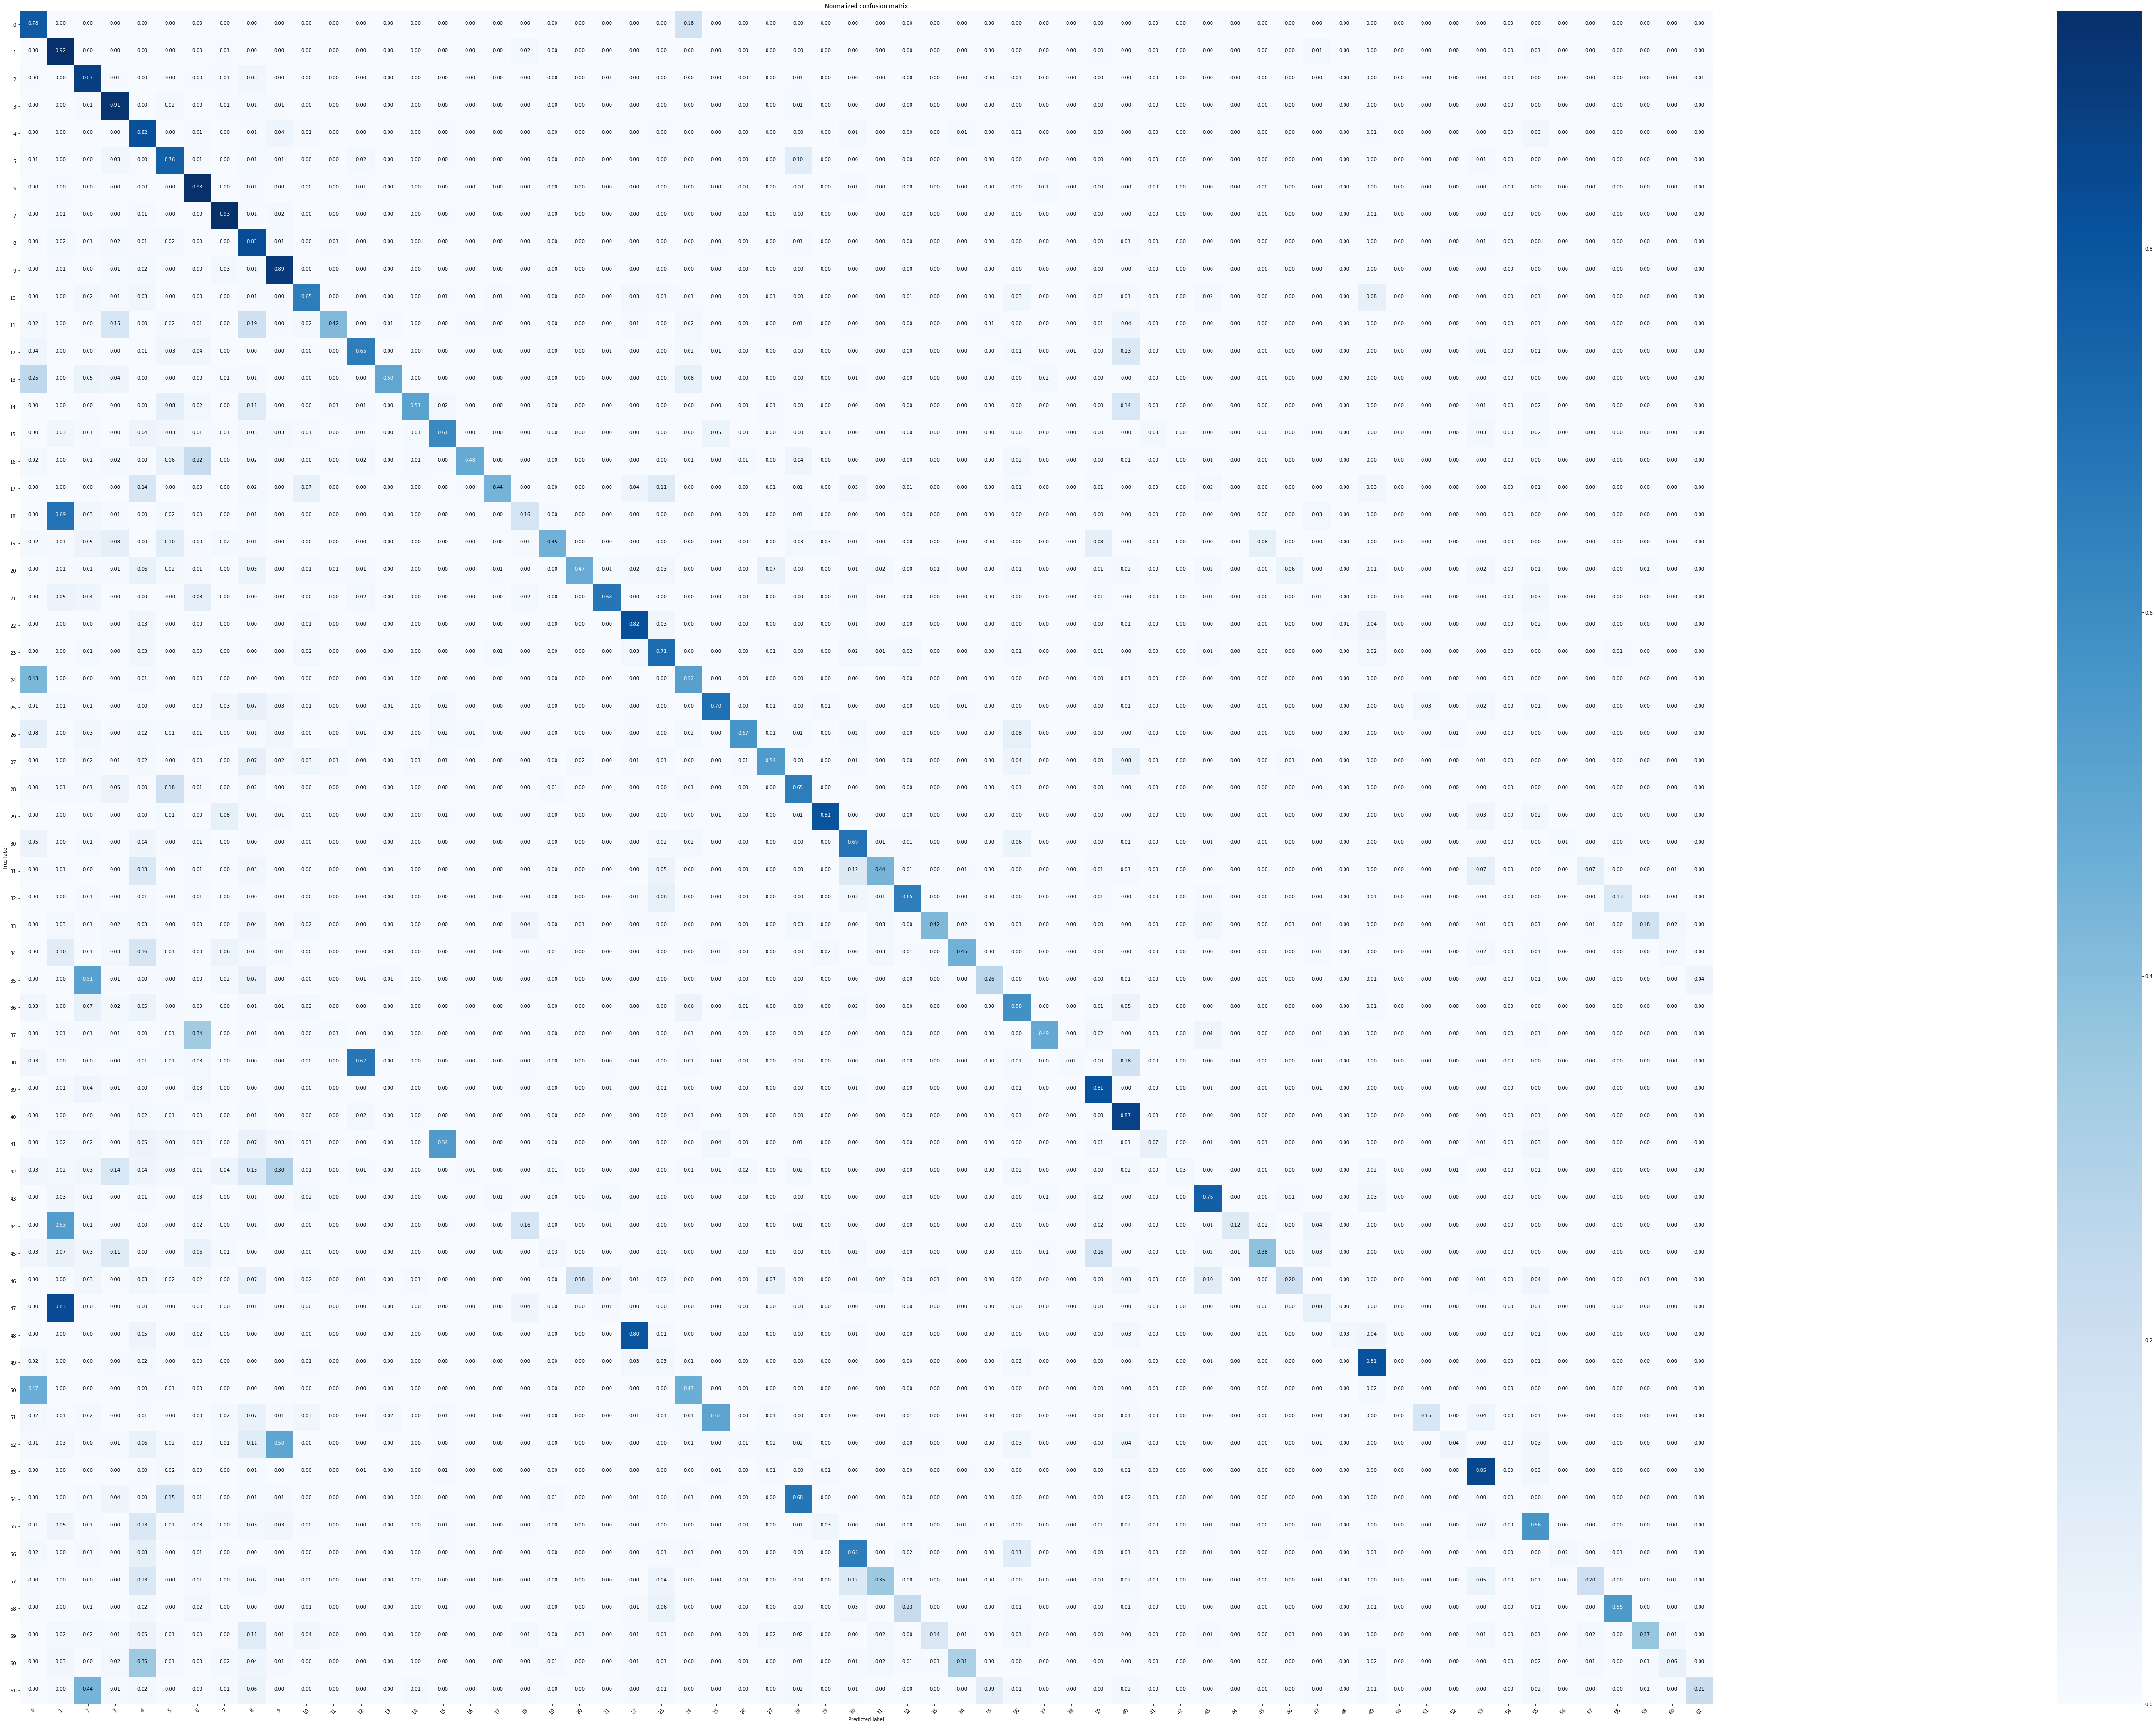

In [104]:
# calculate confusion matrix
cnf_matrix = confusion_matrix(test_labels, pred_lr)

class_names = [i for i in range(num_classes)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(200,50))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('byclass/plot/lr_cm.png')

# Plot normalized confusion matrix
plt.figure(figsize=(200,50))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('byclass/plot/lr_cm_norm.png')
plt.show()

## Using tensorflow/keras

In [21]:
batch_size = 512
num_classes = N_LABELS
epochs = 20

#input image dimensions
img_rows, img_cols = 28, 28
input_shape = (1,img_rows, img_cols)

In [107]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 26, 26)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 13, 13)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 13, 13)        52        
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 13, 13)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 11, 11)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 5, 5)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 5, 5)         20        
__________

In [64]:
from keras.models import load_model
model.save('byclass/cnn_model.h5')  

In [113]:
from keras.callbacks import ModelCheckpoint, TensorBoard
import os, datetime

logdir = "logs/scalars/byclass" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

outpath = "byclass"
if not os.path.exists(outpath):
    os.mkdir(outpath)
filepath= outpath + "/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint, tensorboard_callback]

## Training

- spliting of train/test datasets

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=13)

In [114]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, Y_val), callbacks=callbacks_list)

Train on 640000 samples, validate on 160000 samples
Epoch 1/20
640000/640000 [==============================] - 914s 1ms/step - loss: 0.8120 - acc: 0.7484 - val_loss: 0.5393 - val_acc: 0.8186

Epoch 00001: val_loss improved from inf to 0.53931, saving model to byclass/weights-improvement-01-0.54.hdf5
Epoch 2/20
640000/640000 [==============================] - 904s 1ms/step - loss: 0.6081 - acc: 0.7987 - val_loss: 0.4682 - val_acc: 0.8365

Epoch 00002: val_loss improved from 0.53931 to 0.46823, saving model to byclass/weights-improvement-02-0.47.hdf5
Epoch 3/20
640000/640000 [==============================] - 865s 1ms/step - loss: 0.5367 - acc: 0.8171 - val_loss: 0.4366 - val_acc: 0.8452

Epoch 00003: val_loss improved from 0.46823 to 0.43659, saving model to byclass/weights-improvement-03-0.44.hdf5
Epoch 4/20
640000/640000 [==============================] - 859s 1ms/step - loss: 0.4956 - acc: 0.8284 - val_loss: 0.4148 - val_acc: 0.8513

Epoch 00004: val_loss improved from 0.43659 to 0.

In [115]:
pred_classes = model.predict_classes(x_test)

# Print confusion matrix

In [116]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.69      0.82      0.75      5778
     Class 1       0.68      0.92      0.78      6330
     Class 2       0.95      0.99      0.97      5869
     Class 3       1.00      0.99      1.00      5969
     Class 4       0.97      0.98      0.98      5619
     Class 5       0.97      0.93      0.95      5190
     Class 6       0.97      0.99      0.98      5705
     Class 7       0.99      1.00      0.99      6139
     Class 8       0.98      0.99      0.99      5633
     Class 9       0.92      0.98      0.95      5686
    Class 10       0.94      0.98      0.96      1062
    Class 11       0.95      0.96      0.96       648
    Class 12       0.78      0.97      0.86      1739
    Class 13       0.93      0.89      0.91       779
    Class 14       0.96      0.97      0.97       851
    Class 15       0.80      0.95      0.87      1440
    Class 16       0.96      0.88      0.92       447
    Class 17       0.93    

/root/anaconda3/envs/emnist_py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[4762    1    1 ...    0    0    0]
 [   0 5796    2 ...    0    0    0]
 [   1    1 5792 ...    0    0   14]
 ...
 [   0    0    3 ...  352    3    0]
 [   0    0    1 ...    1  183    0]
 [   0    0  131 ...    2    0  222]]
Normalized confusion matrix
[[8.24e-01 1.73e-04 1.73e-04 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 9.16e-01 3.16e-04 ... 0.00e+00 0.00e+00 0.00e+00]
 [1.70e-04 1.70e-04 9.87e-01 ... 0.00e+00 0.00e+00 2.39e-03]
 ...
 [0.00e+00 0.00e+00 6.38e-03 ... 7.49e-01 6.38e-03 0.00e+00]
 [0.00e+00 0.00e+00 2.62e-03 ... 2.62e-03 4.80e-01 0.00e+00]
 [0.00e+00 0.00e+00 2.90e-01 ... 4.43e-03 0.00e+00 4.92e-01]]


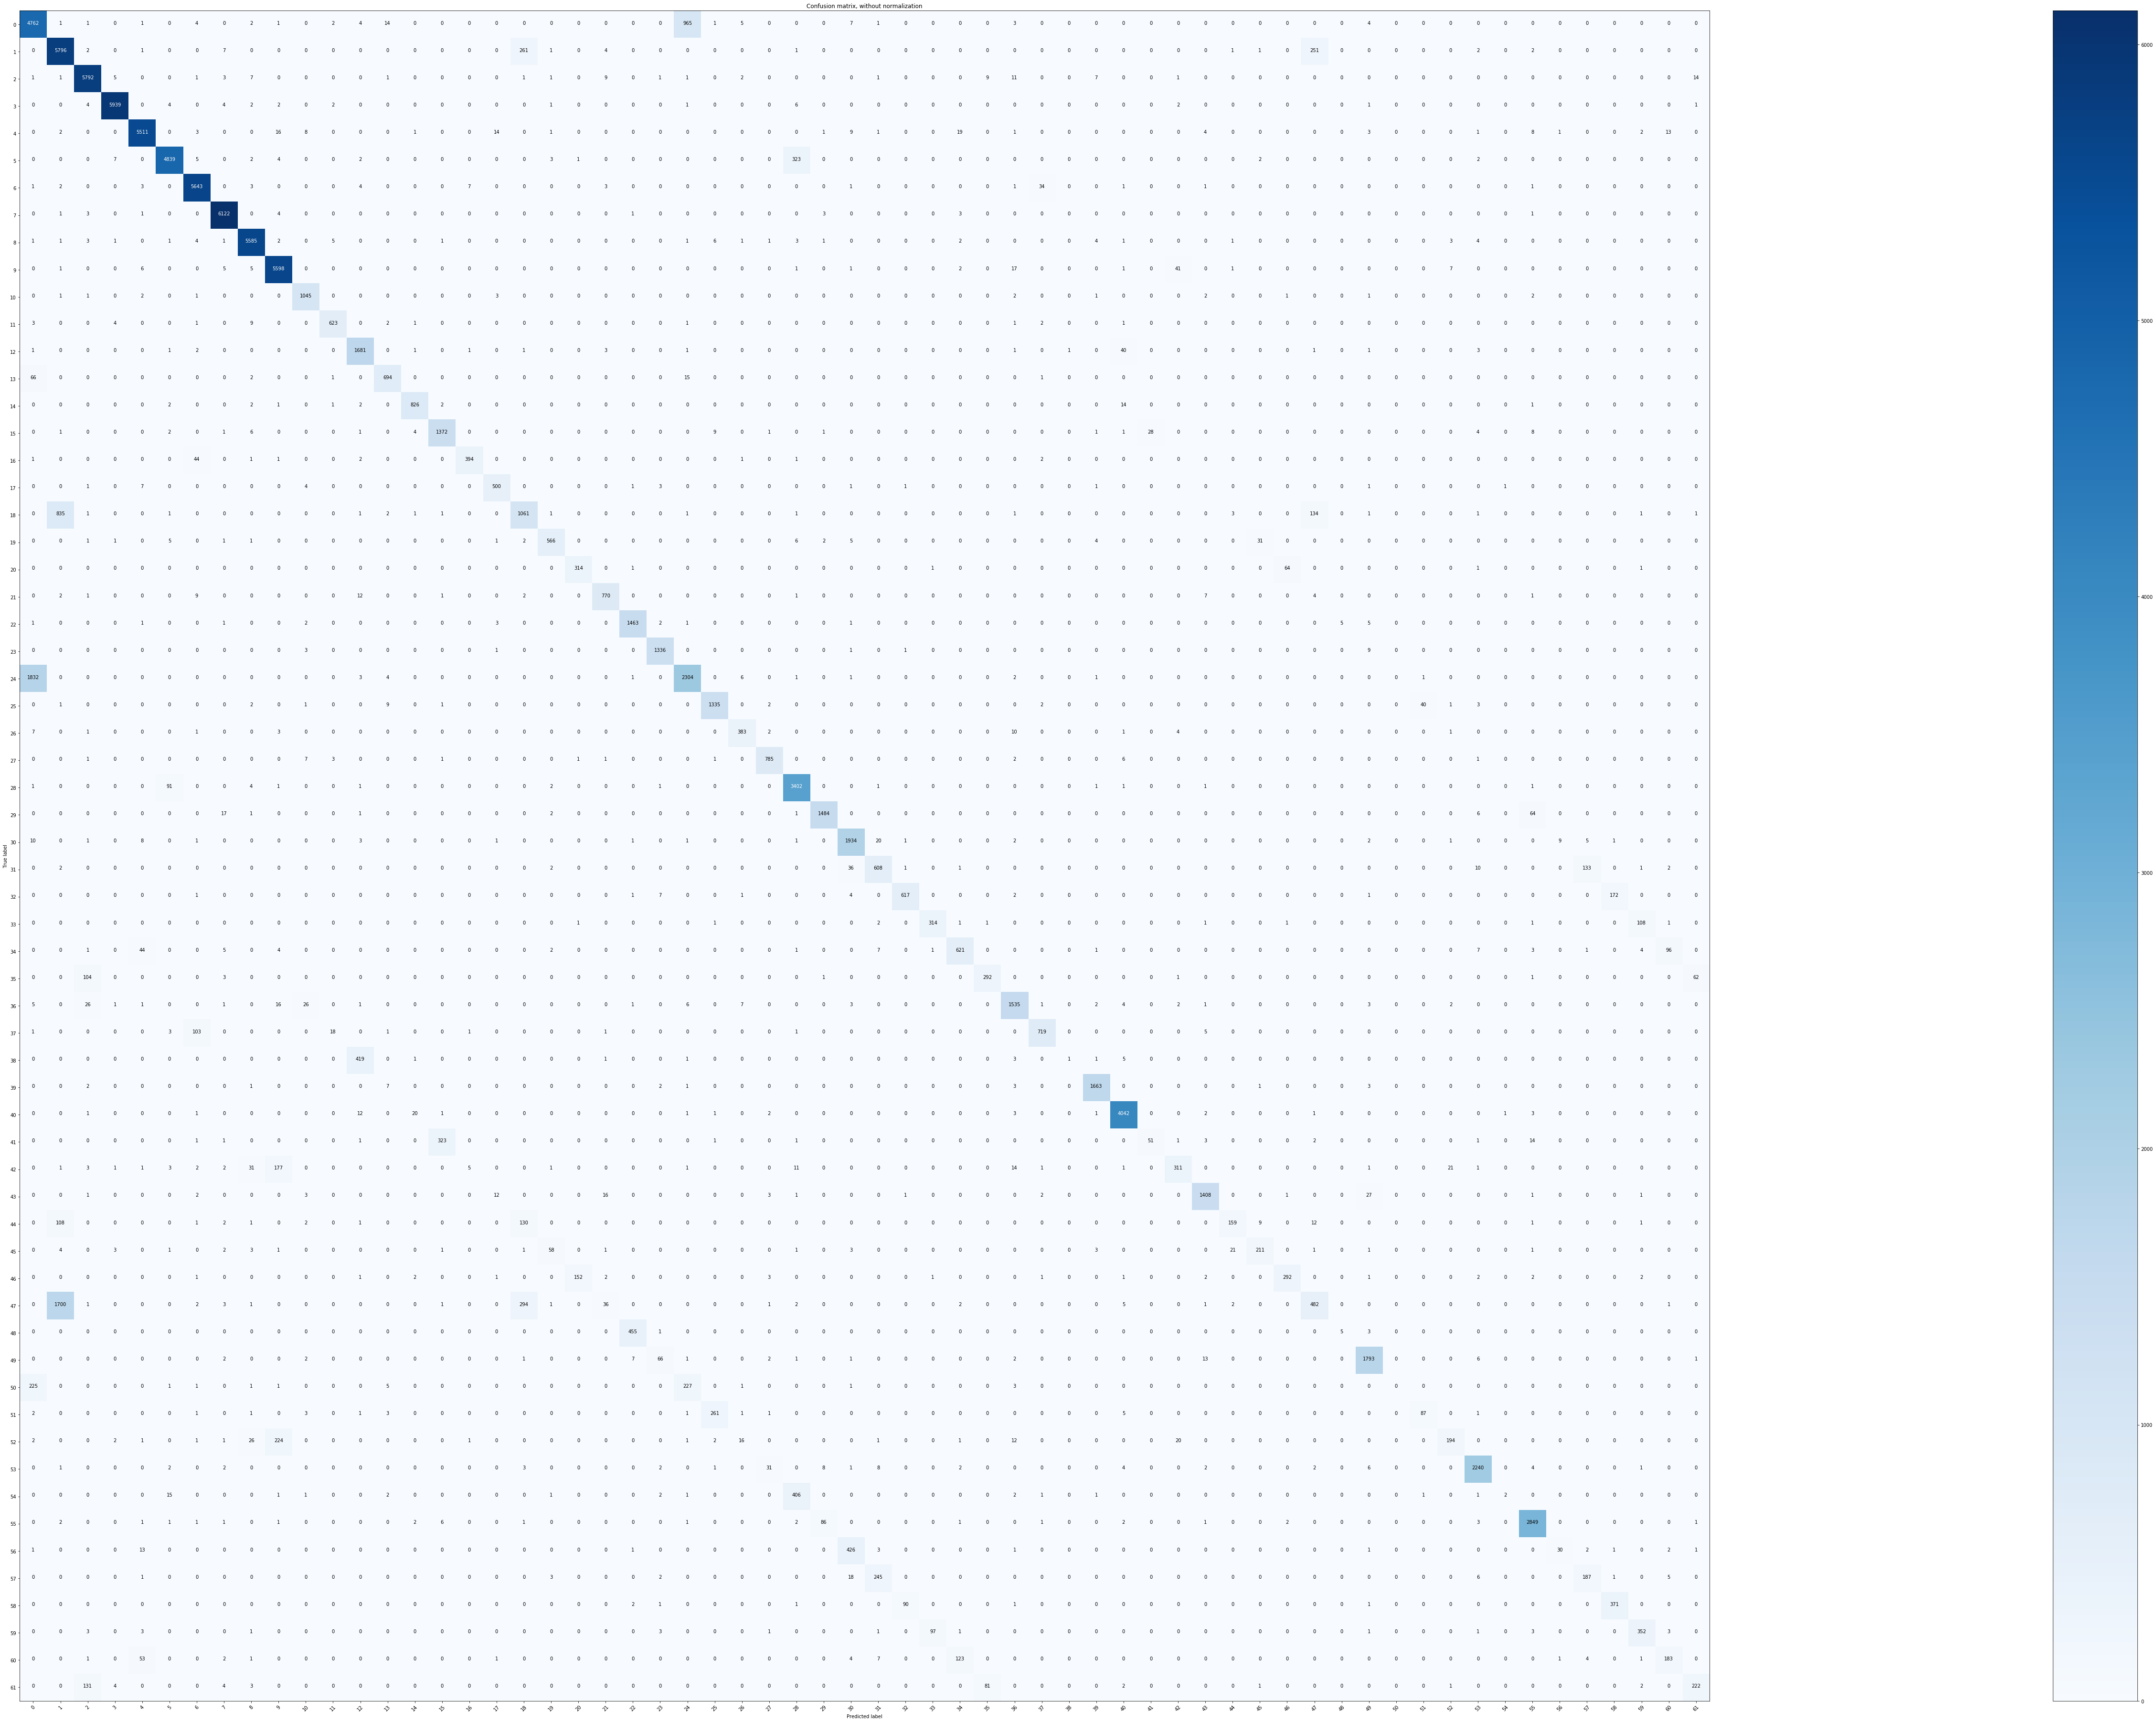

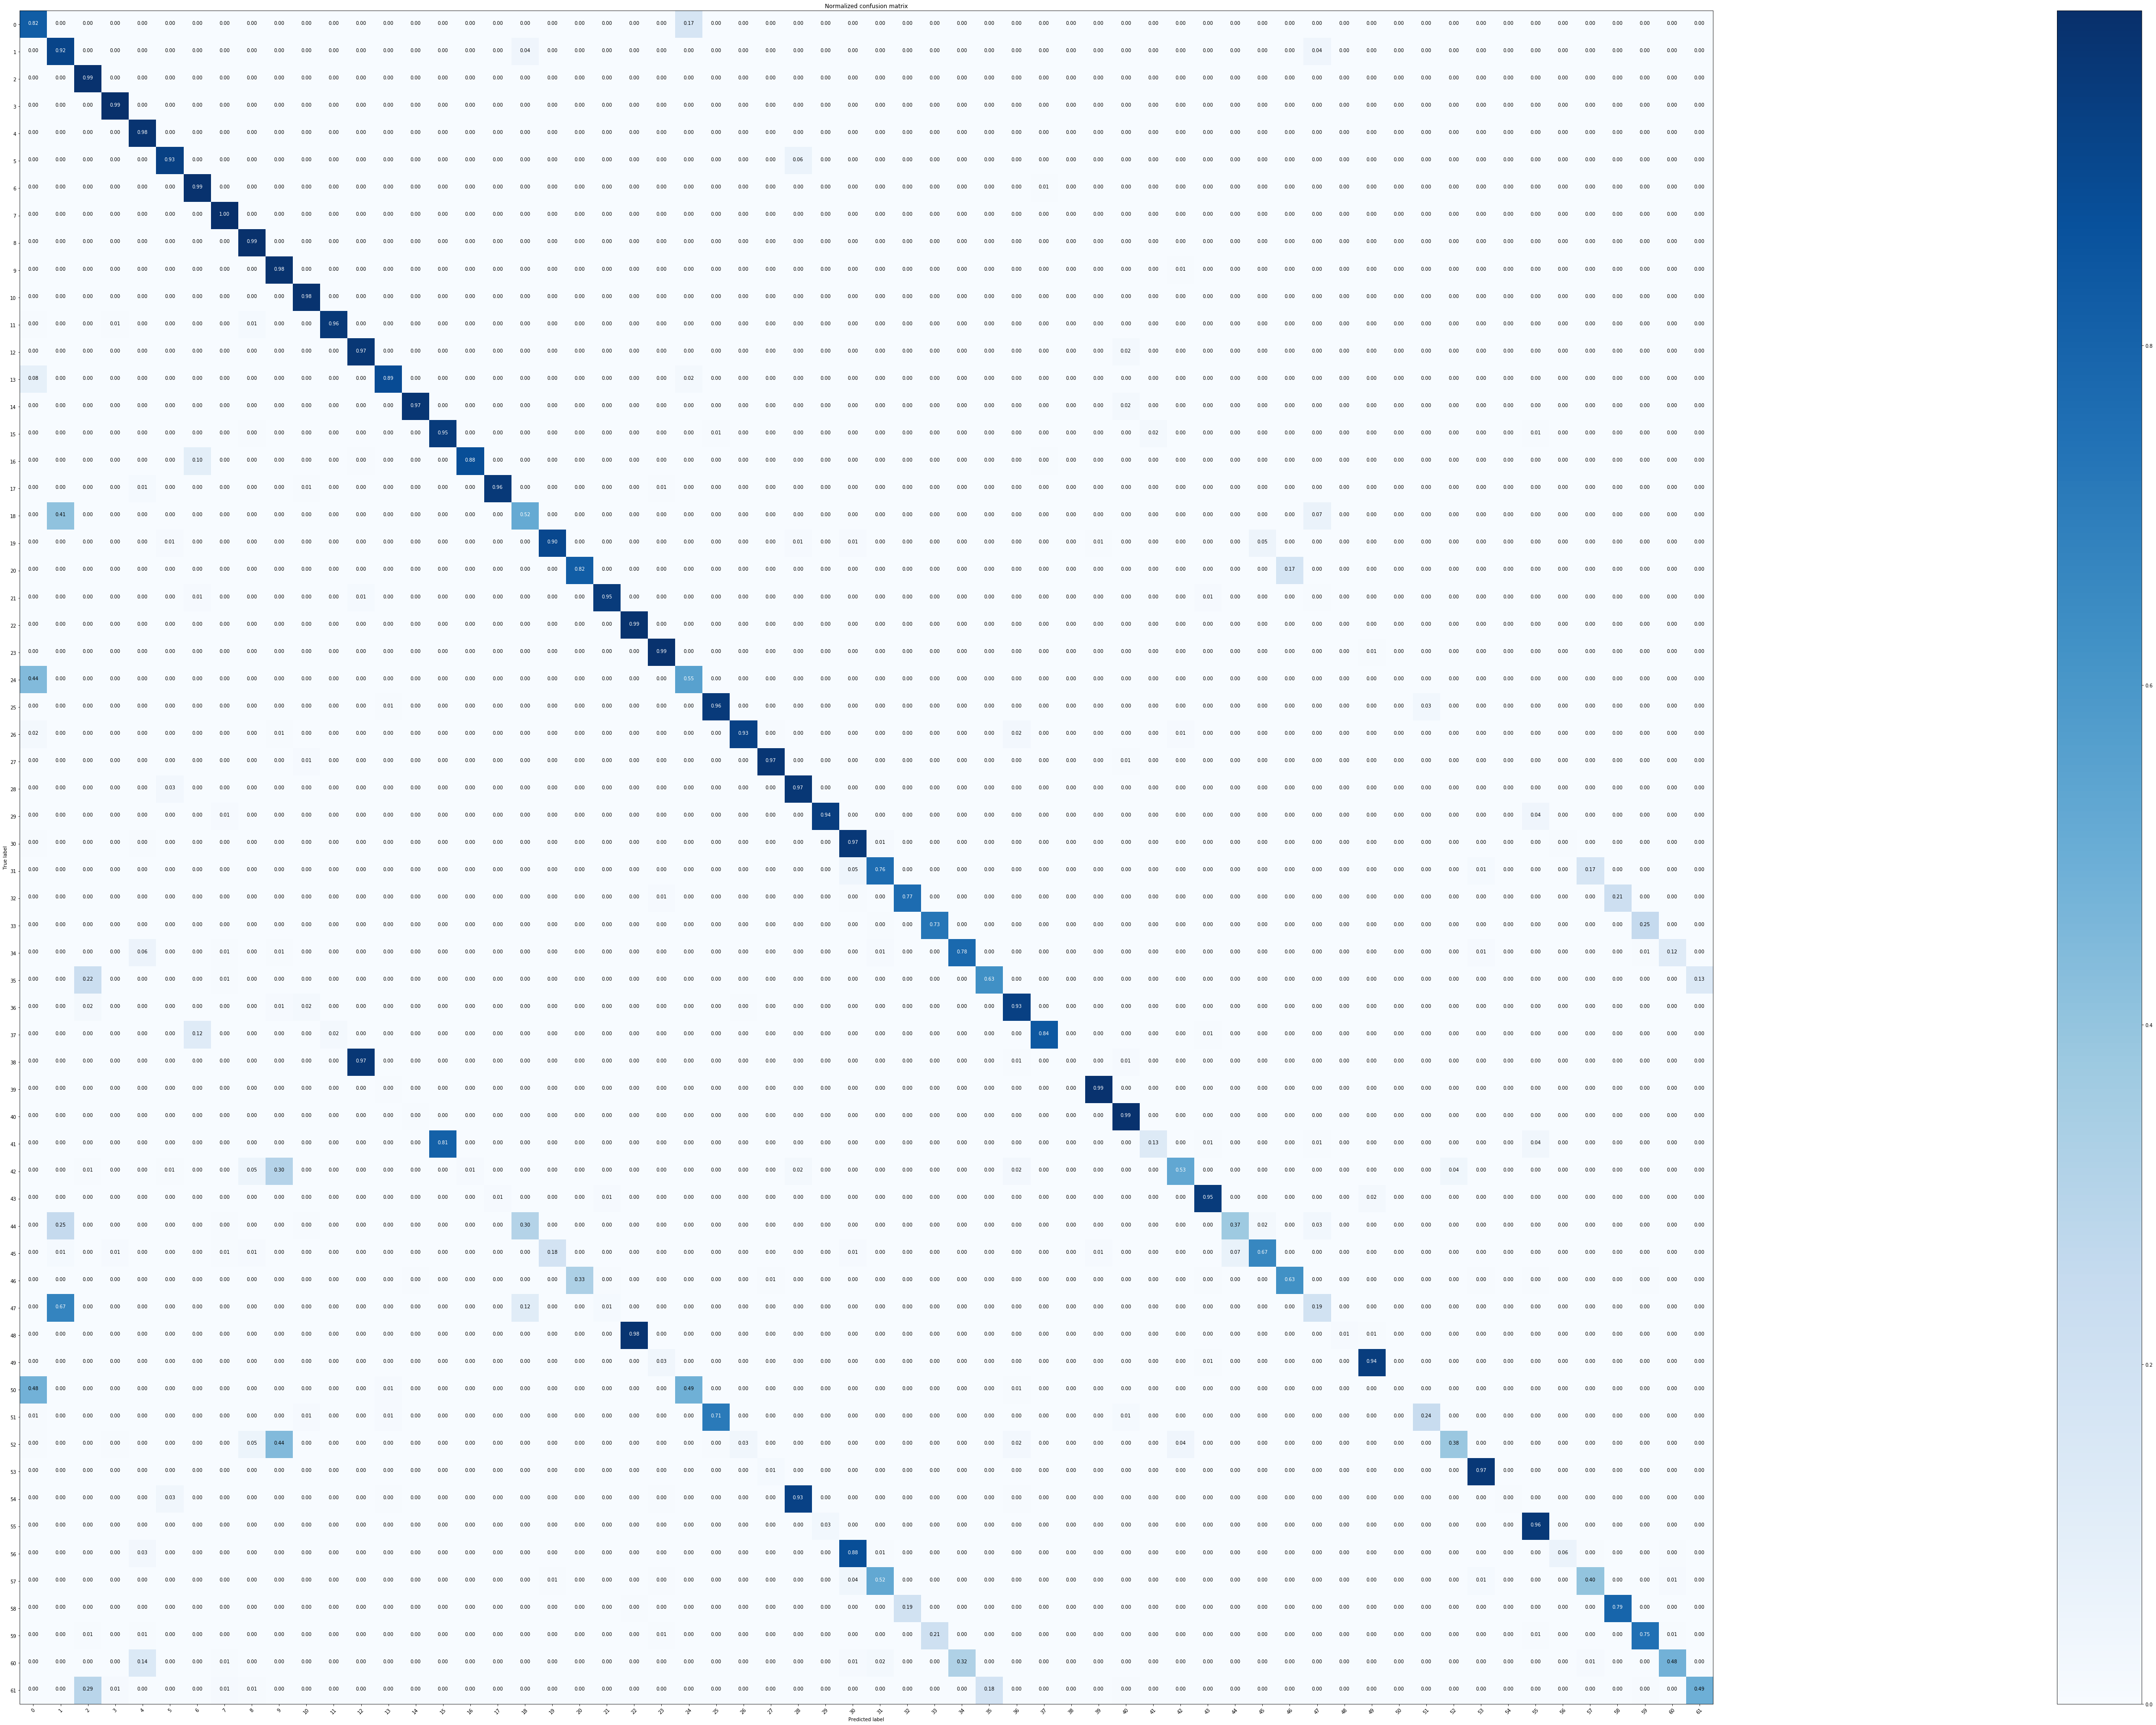

In [117]:
cnf_matrix = confusion_matrix(test_labels, pred_classes)

import itertools

class_names = [i for i in range(num_classes)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(200,50))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('byclass/plot/cnn_cm.png')

# Plot normalized confusion matrix
plt.figure(figsize=(200,50))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('byclass/plot/cnn_cm_norm.png')
plt.show()

# Visualize Predictions
1. A few correct labels at random
2. A few incorrect labels at random

In [118]:
test_labels.shape

(116323,)

In [119]:
correct = np.where(pred_classes==test_labels)[0]
incorrect = np.where(pred_classes!=test_labels)[0]

correct.shape, incorrect.shape

((101700,), (14623,))

In [120]:
# number of images to view
n_view = incorrect.shape[0]

In [121]:
from numpy.random import permutation

# get a random selection of correctly predicted images
idx = permutation(correct)[:n_view]
idx_incorrect = incorrect[:n_view]

In [122]:
preds_correct = pred_classes[idx]
preds_incorrect = pred_classes[idx_incorrect]

In [123]:
imgs = x_test[idx]
imgs_incorrect = x_test[idx_incorrect]

In [124]:
imgs.shape

(14623, 1, 28, 28)

## A few correct labels at random

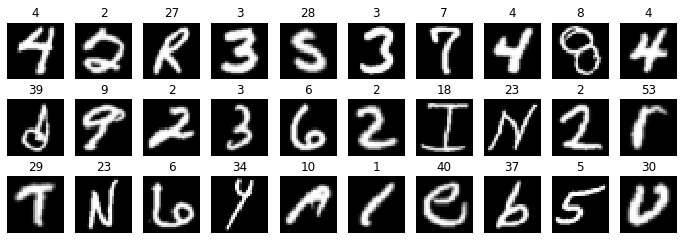

In [125]:
f = plt.figure(figsize=(12,4))

for i in range(30):
    sp = f.add_subplot(3, 10, i+1)
    sp.axis('Off')
    sp.set_title(preds_correct[i])
    img = imgs[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [126]:
# ground truth labels
test_labels[idx]

array([ 4,  2, 27, ...,  5,  9,  8], dtype=uint8)

## A few incorrect labels
Display all predictions not matching ground truth. There are clearly some labeling errors in EMNIST Digits, limiting our overall prediction accuracy.

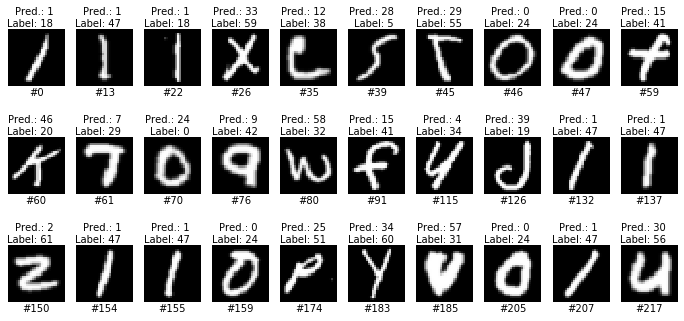

In [127]:
f = plt.figure(figsize=(12,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.15,
                wspace=None, hspace=None)

for i in range(30): 
    sp = f.add_subplot(7, 10, i+1)
    sp.axis('Off')
    sp.text(0.8, 1.2, "Pred.: {}\nLabel: {}"
                 .format(preds_incorrect[i],test_labels[idx_incorrect][i]),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    plt.text(0.5, -0.12, "#{}".format(idx_incorrect[i]), 
             horizontalalignment='center', verticalalignment='center',
             transform=sp.transAxes)
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')

In [128]:
# ground truth labels
test_labels[idx_incorrect]

array([18, 47, 18, ..., 38, 20,  0], dtype=uint8)

In [129]:
idx_incorrect

array([     0,     13,     22, ..., 116290, 116299, 116321])

## Misclassification of lowercase 'F" (class 41)

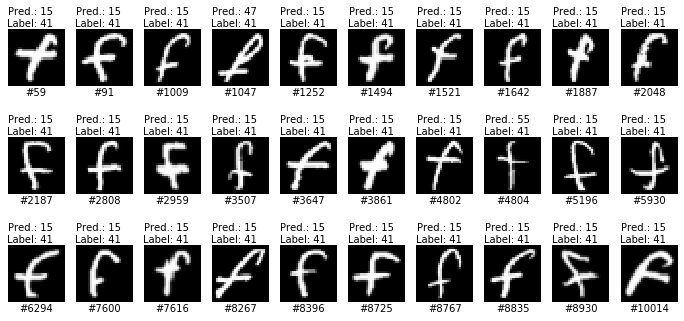

In [166]:
f = plt.figure(figsize=(12,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.15,
                wspace=None, hspace=None)

k=0
 
for i in np.where(test_labels[idx_incorrect]==41)[0][0:30]: 
    sp = f.add_subplot(7, 10, k+1)
    sp.axis('Off')
    sp.text(0.8, 1.2, "Pred.: {}\nLabel: {}"
                 .format(preds_incorrect[i],test_labels[idx_incorrect][i]),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    plt.text(0.5, -0.12, "#{}".format(idx_incorrect[i]), 
             horizontalalignment='center', verticalalignment='center',
             transform=sp.transAxes)
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')
    k=k+1

## Misclassification of lowercase 'O' (class 50)

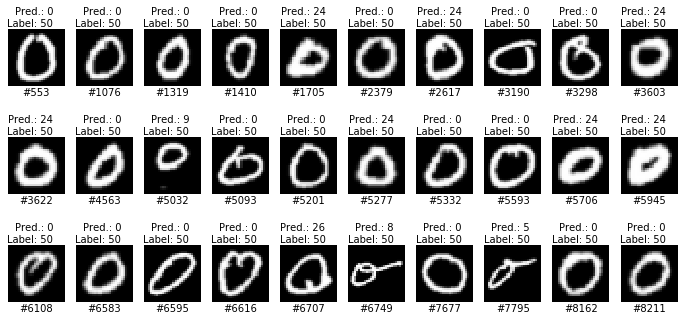

In [168]:
f = plt.figure(figsize=(12,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.15,
                wspace=None, hspace=None)

k=0
 
for i in np.where(test_labels[idx_incorrect]==50)[0][0:30]: 
    sp = f.add_subplot(7, 10, k+1)
    sp.axis('Off')
    sp.text(0.8, 1.2, "Pred.: {}\nLabel: {}"
                 .format(preds_incorrect[i],test_labels[idx_incorrect][i]),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    plt.text(0.5, -0.12, "#{}".format(idx_incorrect[i]), 
             horizontalalignment='center', verticalalignment='center',
             transform=sp.transAxes)
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')
    k=k+1

## Misclassification of lowercase 'S' (class 54)

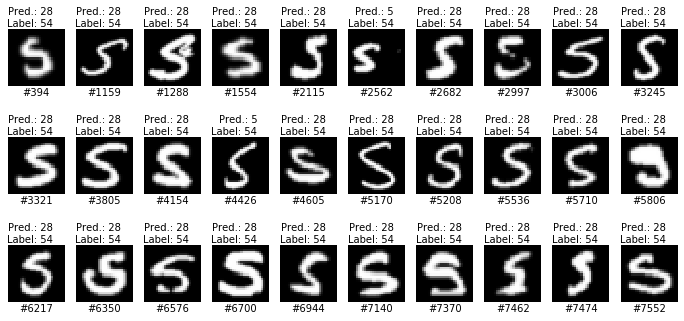

In [165]:
f = plt.figure(figsize=(12,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.15,
                wspace=None, hspace=None)

k=0
 
for i in np.where(test_labels[idx_incorrect]==54)[0][0:30]: 
    sp = f.add_subplot(7, 10, k+1)
    sp.axis('Off')
    sp.text(0.8, 1.2, "Pred.: {}\nLabel: {}"
                 .format(preds_incorrect[i],test_labels[idx_incorrect][i]),
            horizontalalignment='right', verticalalignment='center',
            transform=sp.transAxes)
    plt.text(0.5, -0.12, "#{}".format(idx_incorrect[i]), 
             horizontalalignment='center', verticalalignment='center',
             transform=sp.transAxes)
    img = imgs_incorrect[i].astype('float32')
    plt.imshow(img[0], cmap='gray')
    k=k+1

## Capsule Network

In [23]:
from keras import layers, models, optimizers
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

x = layers.Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

# Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

# Layer 3: Capsule layer. Routing algorithm works here.
digitcaps = CapsuleLayer(num_capsule=num_classes, dim_capsule=16, num_routing=3,
                         name='digitcaps')(primarycaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
out_caps = Length(name='capsnet')(digitcaps)

# Decoder network.
y = layers.Input(shape=(num_classes,))
masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

# Shared Decoder model in training and prediction
decoder = models.Sequential(name='decoder')
decoder.add(layers.Dense(512, activation='relu', input_dim=16*num_classes))
decoder.add(layers.Dense(1024, activation='relu'))
decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

# Models for training and evaluation (prediction)
model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
eval_model = models.Model(x, [out_caps, decoder(masked)])

model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 20, 20)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 256, 6, 6)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
______________________________________________

In [29]:
from keras.callbacks import ModelCheckpoint, TensorBoard
import os, datetime

outpath = "byclass/Capsnet2"

logdir = "logs/scalars/byclass" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

if not os.path.exists(outpath):
    os.mkdir(outpath)
filepath= outpath + "/weights-improvement-{epoch:02d}-{val_capsnet_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_capsnet_loss', verbose=1, save_best_only=True)
callbacks_list = [checkpoint, tensorboard_callback]

In [30]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [33]:
# compile the model
model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss=[margin_loss, 'mse'],
              loss_weights=[1., 0.392],
              metrics={'capsnet': 'accuracy'})

# Train
history = model.fit([X_train, Y_train], [Y_train, X_train], batch_size=batch_size, epochs=5,
          verbose=1, validation_data=[[X_val, Y_val], [Y_val, X_val]], callbacks=callbacks_list)


Train on 640000 samples, validate on 160000 samples
Epoch 1/5
640000/640000 [==============================] - 4904s 8ms/step - loss: 0.8437 - capsnet_loss: 0.8100 - decoder_loss: 0.0860 - capsnet_acc: 0.0283 - val_loss: 0.8419 - val_capsnet_loss: 0.8100 - val_decoder_loss: 0.0814 - val_capsnet_acc: 0.0354

Epoch 00001: val_capsnet_loss improved from 0.81000 to 0.81000, saving model to Capsnet2/weights-improvement-01-0.81.hdf5
Epoch 2/5
640000/640000 [==============================] - 4794s 7ms/step - loss: 0.2826 - capsnet_loss: 0.2567 - decoder_loss: 0.0662 - capsnet_acc: 0.6915 - val_loss: 0.1938 - val_capsnet_loss: 0.1697 - val_decoder_loss: 0.0616 - val_capsnet_acc: 0.7962

Epoch 00002: val_capsnet_loss improved from 0.81000 to 0.16966, saving model to Capsnet2/weights-improvement-02-0.17.hdf5
Epoch 3/5
640000/640000 [==============================] - 4825s 8ms/step - loss: 0.1750 - capsnet_loss: 0.1513 - decoder_loss: 0.0605 - capsnet_acc: 0.8144 - val_loss: 0.1624 - val_capsnet_

In [46]:
caps_pred, _ = eval_model.predict(x_test, batch_size=batch_size)
caps_pred = np.argmax(caps_pred, 1)

In [47]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, caps_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.67      0.81      0.73      5778
     Class 1       0.66      0.94      0.77      6330
     Class 2       0.92      0.98      0.95      5869
     Class 3       0.98      0.99      0.99      5969
     Class 4       0.95      0.97      0.96      5619
     Class 5       0.93      0.92      0.93      5190
     Class 6       0.96      0.98      0.97      5705
     Class 7       0.98      0.99      0.98      6139
     Class 8       0.95      0.98      0.97      5633
     Class 9       0.91      0.98      0.94      5686
    Class 10       0.91      0.96      0.93      1062
    Class 11       0.91      0.88      0.90       648
    Class 12       0.76      0.94      0.85      1739
    Class 13       0.91      0.81      0.86       779
    Class 14       0.96      0.94      0.95       851
    Class 15       0.77      0.95      0.85      1440
    Class 16       0.91      0.82      0.86       447
    Class 17       0.90    

Confusion matrix, without normalization
[[4681    1    2 ...    0    0    0]
 [   0 5927   14 ...    0    0    0]
 [   0    1 5745 ...    2    0   33]
 ...
 [   0    1    2 ...  334    2    2]
 [   0    0    0 ...    2   29    0]
 [   0    0  150 ...    3    0  206]]
Normalized confusion matrix
[[8.10e-01 1.73e-04 3.46e-04 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 9.36e-01 2.21e-03 ... 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.70e-04 9.79e-01 ... 3.41e-04 0.00e+00 5.62e-03]
 ...
 [0.00e+00 2.13e-03 4.26e-03 ... 7.11e-01 4.26e-03 4.26e-03]
 [0.00e+00 0.00e+00 0.00e+00 ... 5.25e-03 7.61e-02 0.00e+00]
 [0.00e+00 0.00e+00 3.33e-01 ... 6.65e-03 0.00e+00 4.57e-01]]


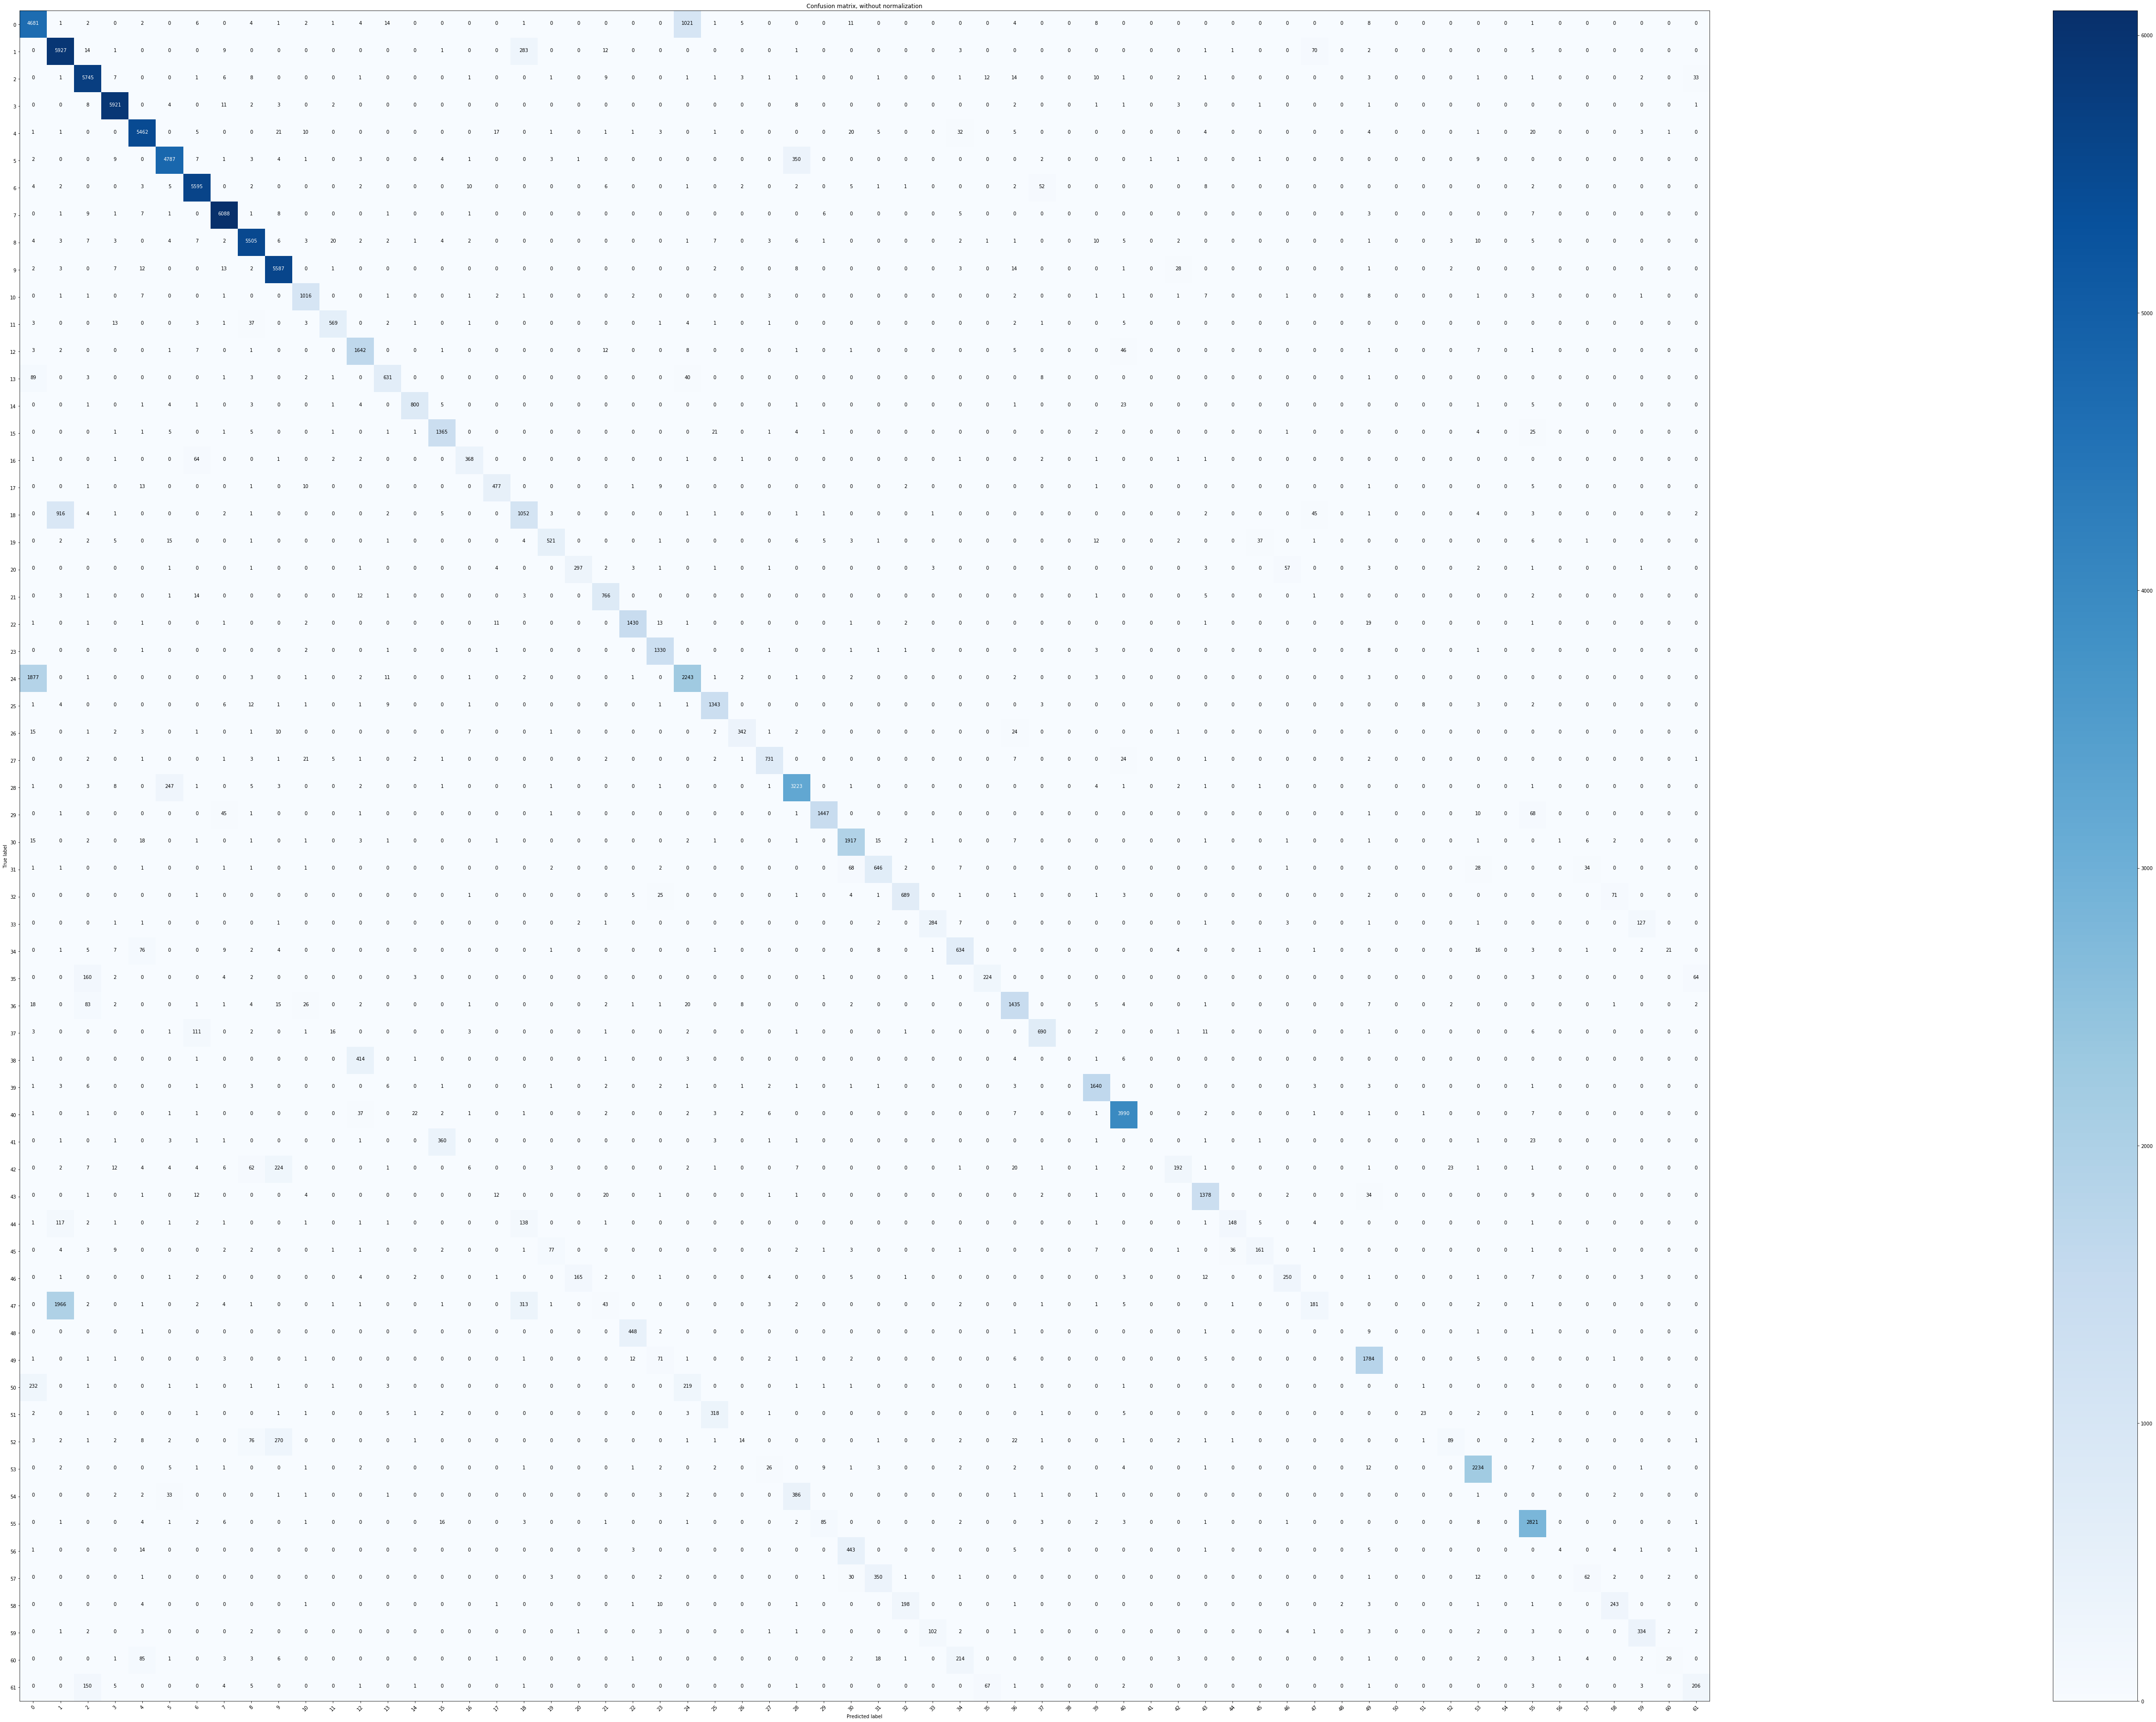

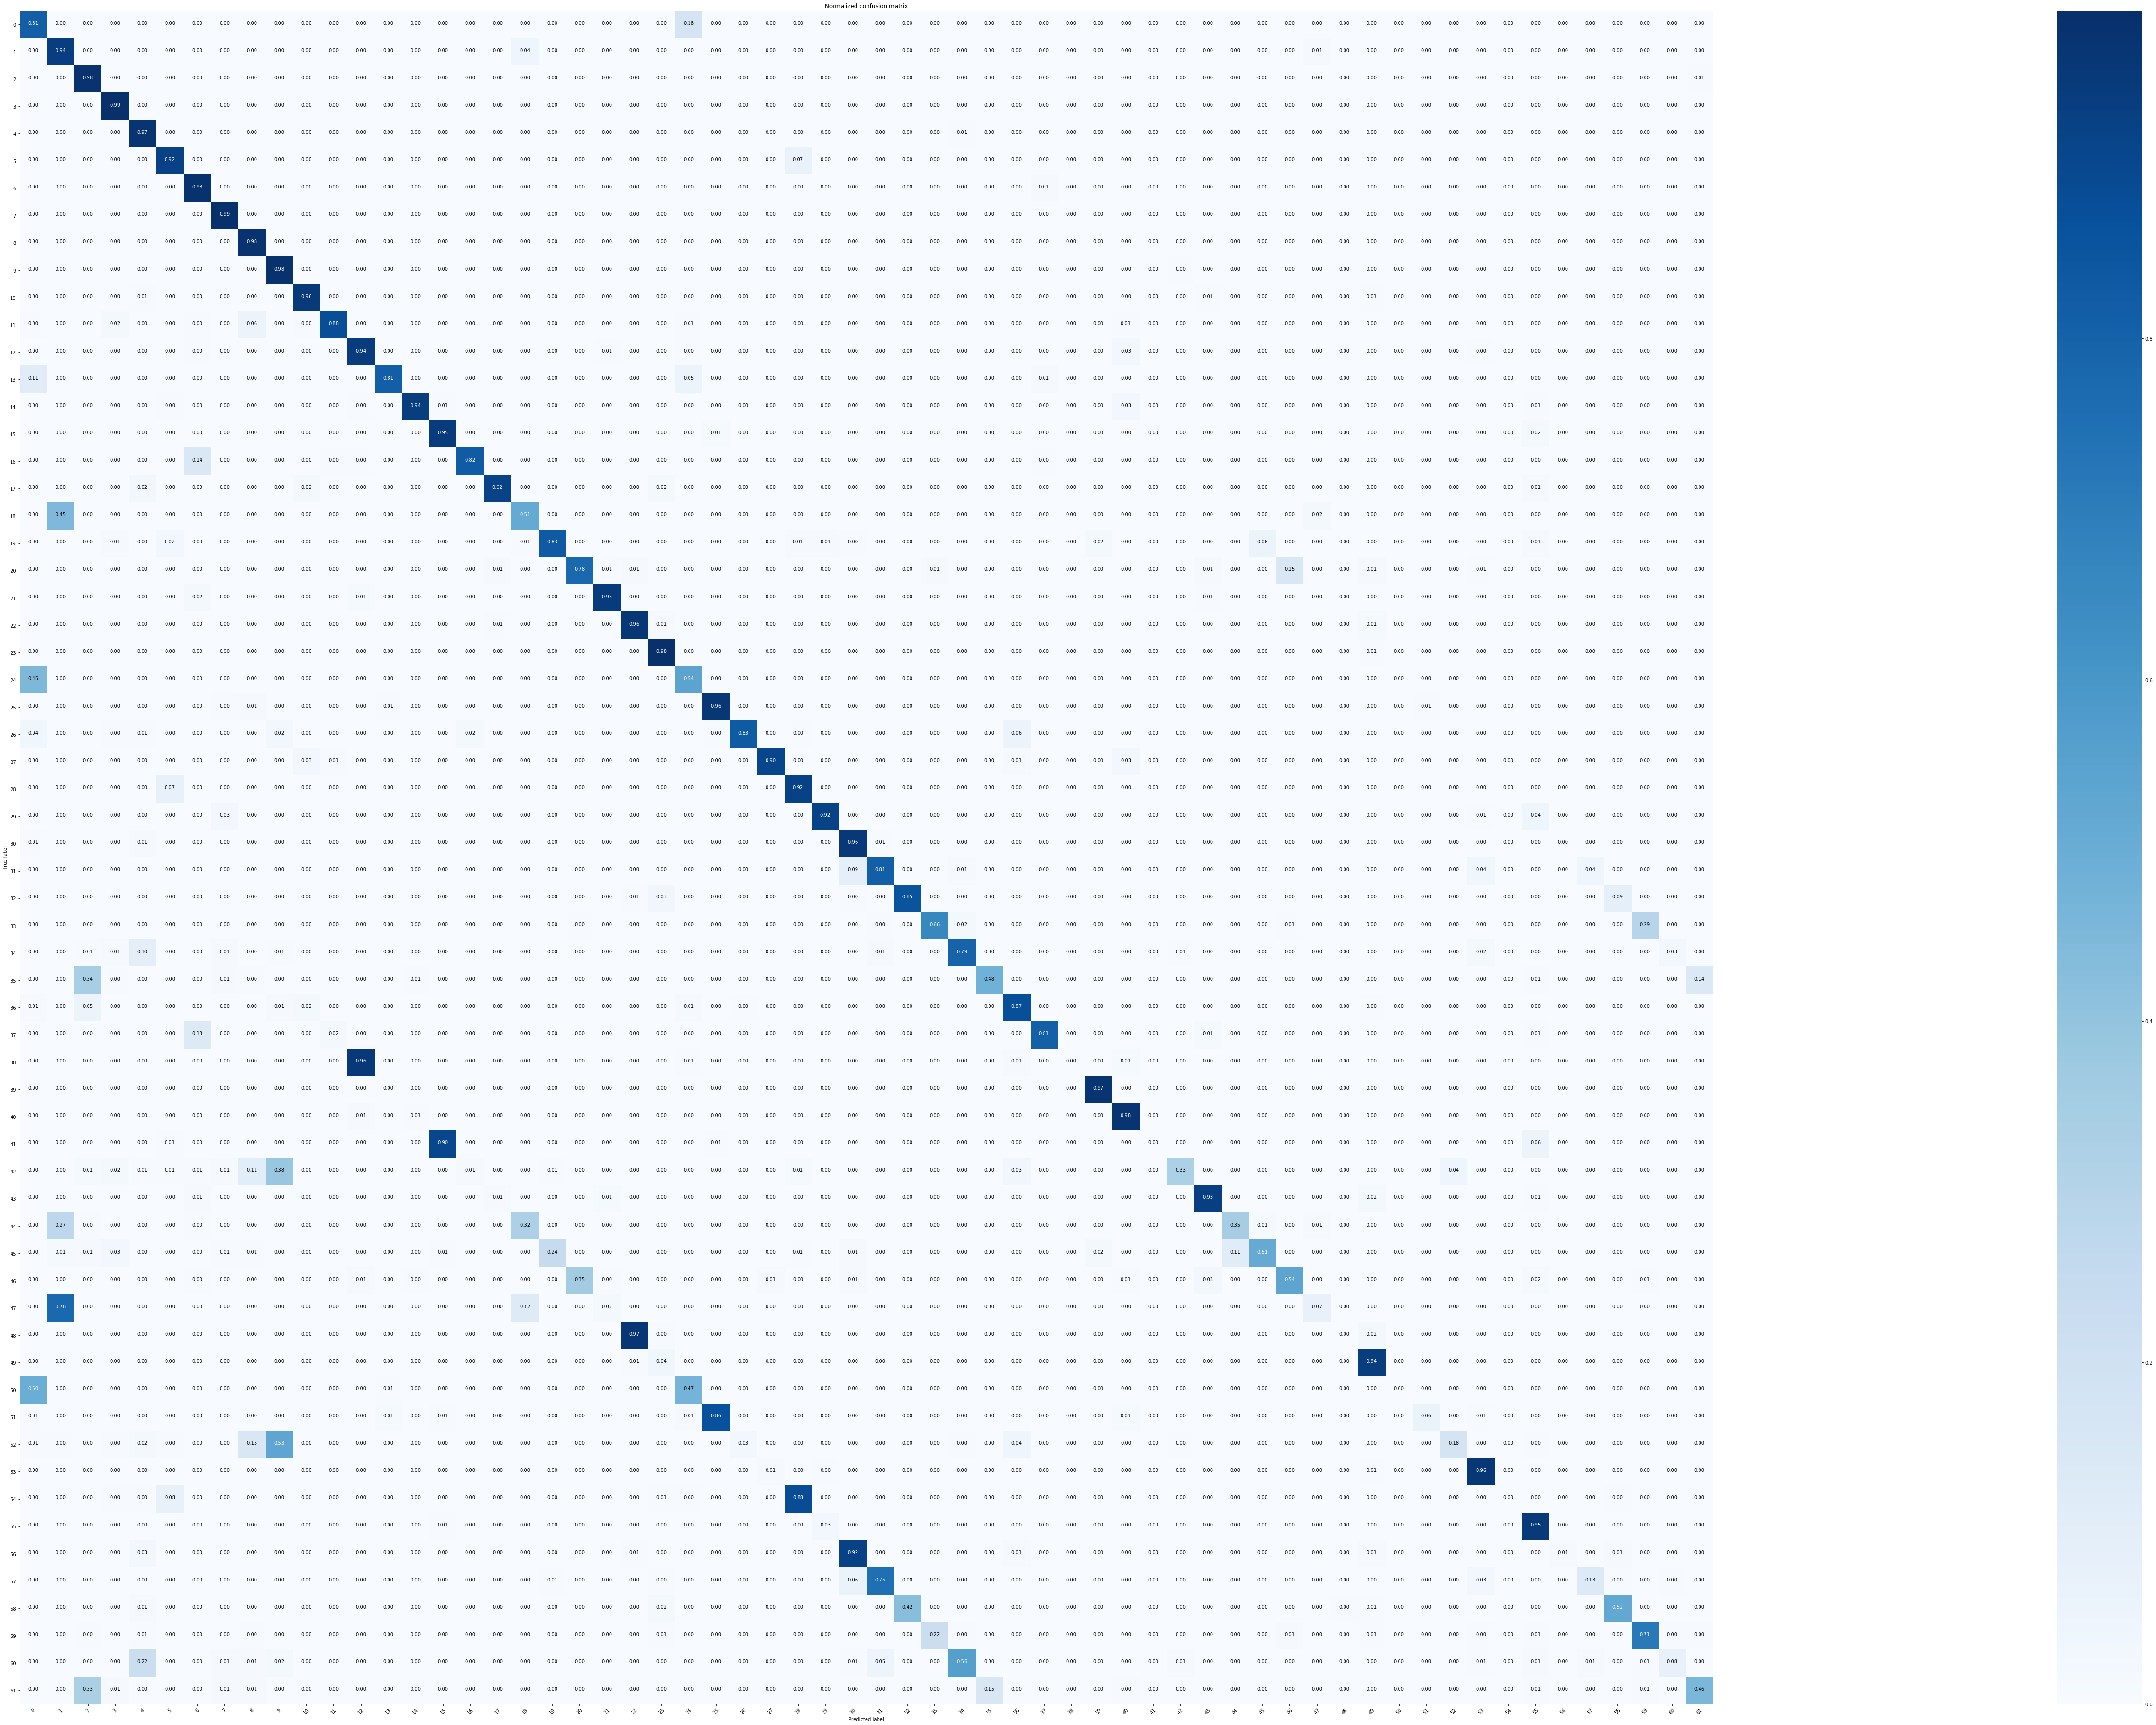

In [48]:
cnf_matrix = confusion_matrix(test_labels, caps_pred)

import itertools

class_names = [i for i in range(num_classes)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(200,50))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig('byclass/plot/capsule_cm.png')

# Plot normalized confusion matrix
plt.figure(figsize=(200,50))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('byclass/plot/capsule_cm_norm.png')
plt.show()